
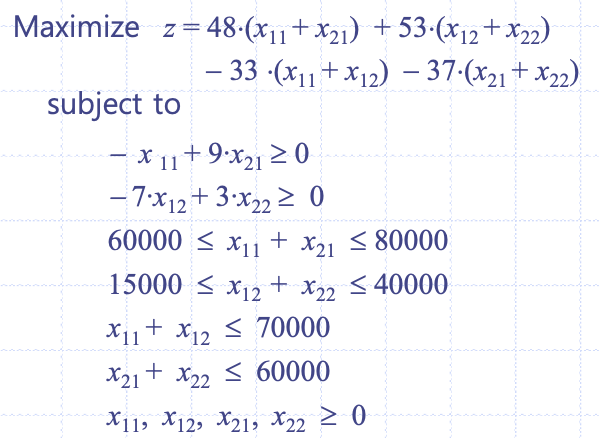

Extracted Math Problem: Maximize z = 48(x_11 + x_21) + 53(x_12 + x_22) - 33(x_11 + x_12) - 37(x_21 + x_22)

subject to

-x_11 + 9x_21 >= 0  
-7x_12 + 3x_22 >= 0  
60000 <= x_11 + x_21 <= 80000  
15000 <= x_12 + x_22 <= 40000  
x_11 + x_12 <= 70000  
x_21 + x_22 <= 60000  
x_11, x_12, x_21, x_22 >= 0  
Standard Form: 
 주어진 문제를 표준형으로 변환하기 위해서는 목적 함수와 제약 조건을 모두 <= 형태로 변환하고, 모든 변수는 좌변에, 상수는 우변에 위치하도록 해야 합니다.

1. 목적 함수:
   Maximize z = 48x_11 + 48x_21 + 53x_12 + 53x_22 - 33x_11 - 33x_12 - 37x_21 - 37x_22
   = (48 - 33)x_11 + (53 - 33)x_12 + (48 - 37)x_21 + (53 - 37)x_22
   = 15x_11 + 20x_12 + 11x_21 + 16x_22

2. 제약 조건을 <= 형태로 변환:

   -x_11 + 9x_21 >= 0  -->  x_11 - 9x_21 <= 0

   -7x_12 + 3x_22 >= 0  -->  7x_12 - 3x_22 <= 0

   60000 <= x_11 + x_21 <= 80000  -->  x_11 + x_21 >= 60000  -->  -x_11 - x_21 <= -60000
                                      x_11 + x_21 <= 80000

   15000 <= x_12 + x_22 <= 40000  -->  x_12 + x_22 >= 15000  -->  -x_12 - x_22 <= -15000
                                

In [9]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_teddynote.models import MultiModal
from langchain_experimental.tools import PythonREPLTool
from langchain_experimental.utilities import PythonREPL

class LPSolver:
    def __init__(self):
        # Load environment variables
        load_dotenv()
        os.environ["LANGCHAIN_PROJECT"] = "Real World Challenge_LP SOLVER"

        # Initialize models and tools
        self.image_to_code_model = ChatOpenAI(temperature=0, model_name="gpt-4o")
        self.math_to_math_model = ChatOpenAI(temperature=0, model_name="gpt-4o")
        self.math_to_code_model = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
        self.python_tool = PythonREPL()

        # Initialize system and user prompts
        self.system_prompt = """
            LP 과목의 이해를 돕는 조교야. 주어진 LP 문제 이미지 혹은 문제의 상황을 형식에 맞게 글로 다시 적어줘.
            형식에 대한 예시도 줄게. 예시처럼 적어줘.

            예시 :
            maximize 3x_1 + 2x_2
            subject to
            x_1 + 2x_2 <= 4
            x_1 + x_2 <= 2
            x_1, x_2 >= 0
        """
        self.user_prompt = """
            다음의 문제상황 혹은 LP 문제 이미지를 해당하는 형식에 맞게 LP Formulation 해줘. 
            분, 시간 단위에 유의해서 분으로 단위를 통일해서 적어줘.
            금액은 만원이 아니라 원 단위로 적어줘.
            LaTeX 코드 형식으로 말고 일반 텍스트 형식으로 출력해줘.
        """

    def extract_math_problem(self, image_path: str) -> str:
        multimodal_model = MultiModal(
            self.image_to_code_model,
            system_prompt=self.system_prompt,
            user_prompt=self.user_prompt
        )
        return multimodal_model.invoke(image_path)
    
    def check_math_again(self, math_problem: str) -> str:
        prompt = PromptTemplate.from_template(
            """
            주어진 {math}를 standard form으로 다시 작성해줘.
            괄호는 모두 벗겨서 수식으로 적고, 조건식은 우변에 상수만 남게 변수들은 모두 좌변으로 넘겨줘. 
            조건식의 부등호는 <=이도록 식을 정리해줘. LaTeX를 사용하지 말고 적어줘. 
            """
        )
        chain = prompt | self.math_to_math_model | StrOutputParser()
        return chain.invoke({"math": math_problem})

    def generate_scipy_code(self, problem_description: str) -> str:
        prompt = PromptTemplate.from_template(
            """
            {problem}을 SciPy 라이브러리의 optimize 모듈의 linprog 함수를 사용해서 풀 수 있도록 코드를 만들어.
            문제를 풀기 전에 목점함수가 min문제면 i=0, max문제면 i=1로 값을 할당해줘.
            그리고 마지막 결과값을 출력할 때 i==0이면 그냥 출력하고, i==1이면 Objective value에 -1을 곱해서 출력해.

            행렬을 구성할 때 변수의 순서에 유의해서 적어줘.

            그리고 Optimal Solution도 출력해줘.
            바로 실행할 수 있도록 코드만 적어줘.

            결과 출력은 아래의 형태로 해줘.

            If the solution is infeasible, then print out with 'print("It is infeasible")'.
            If the solution is unbounded, then print out with 'print("It is unbounded")'.
            """
        )
        chain = prompt | self.math_to_code_model | StrOutputParser()
        return chain.invoke({"problem": problem_description})

    def execute_code(self, code: str) -> str:
        try:
            return self.python_tool.run(code)
        except Exception as e:
            return f"Failed to execute.\nCode: {code}\nError: {type(e).__name__} - {e}"

    def solve_lp_problem(self, image_path: str) -> str:
        # Step 1: Extract math problem from image
        math_problem = self.extract_math_problem(image_path)
        print("Extracted Math Problem:", math_problem)

        # Step 2:  Check the problem again to suit the code
        check_math_again = self.check_math_again(math_problem)
        print("Standard Form: \n", check_math_again)

        # Step 3: Generate Python code for solving the problem
        scipy_code = self.generate_scipy_code(check_math_again)
        print("Generated SciPy Code:\n", scipy_code)

        # Step 3: Execute the generated code
        result = self.execute_code(scipy_code)
        print("Execution Result:", result)

        return result

if __name__ == "__main__":
    IMAGE_PATH = "/Users/user/Documents/GitHub/RWC_LP/problem_set/22ans.png"
    solver = LPSolver()
    solver.solve_lp_problem(IMAGE_PATH)
